# Election Tweets Overall Analysis

This notebook analyses all the tweets that have been scraped. It also splits out by Biden vs. Trump supporting tweets by using popular hashtags. 
Analysis methods include Sentiment Analysis using the NRC Lexicon, Wordclouds among others. 

In [25]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
import seaborn as sns
sns.set_style('darkgrid')
from ast import literal_eval
import random
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
import datetime
from nrclex import NRCLex
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")
df=pd.read_csv('Election_Tweets_Master.csv', index_col=0)
#df.head()

# Sentiment

The NRC Emotional Lexicon is a list of approx. 27k English words and their associations with 8 different emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust) and two sentiments (negative and positive). 
We will use this (with a neat Python package) to help assess the emotion and sentiment of our tweets. Is it going to be perfect? No. This is not an exact science. But it's definitely a start when dealing with unlabelled data. 

In [26]:
emot_sent=pd.DataFrame(df['contents'].copy(),columns=['contents'])
list_emots=[]
for idx, tweet in df.iterrows():
    list_emots.append([])
    text_object=NRCLex(tweet.contents)
    for emotion in text_object.affect_frequencies.keys():
        list_emots[idx].append(text_object.affect_frequencies[emotion])
df_emots=pd.DataFrame(list_emots, columns=['fear','anger','anticipation','trust','surprise','positive','negative', 'sadness', 'disgust', 'joy'])
        
emot_sent=emot_sent.join(df_emots)
#emot_sent.head()

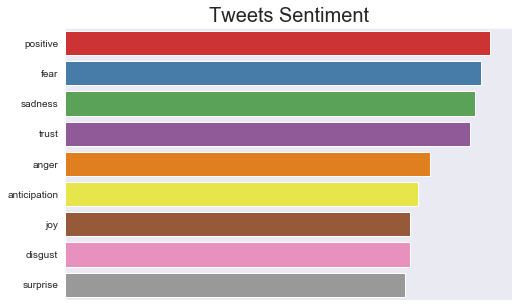

In [27]:
feelings=emot_sent.sum(axis=0).iloc[1:]
feelings.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(8,5))
sns.barplot(x=feelings.iloc[1:].values, y=feelings.index[1:], palette='Set1')
plt.xticks([],[])
plt.title('Tweets Sentiment', fontsize=20);

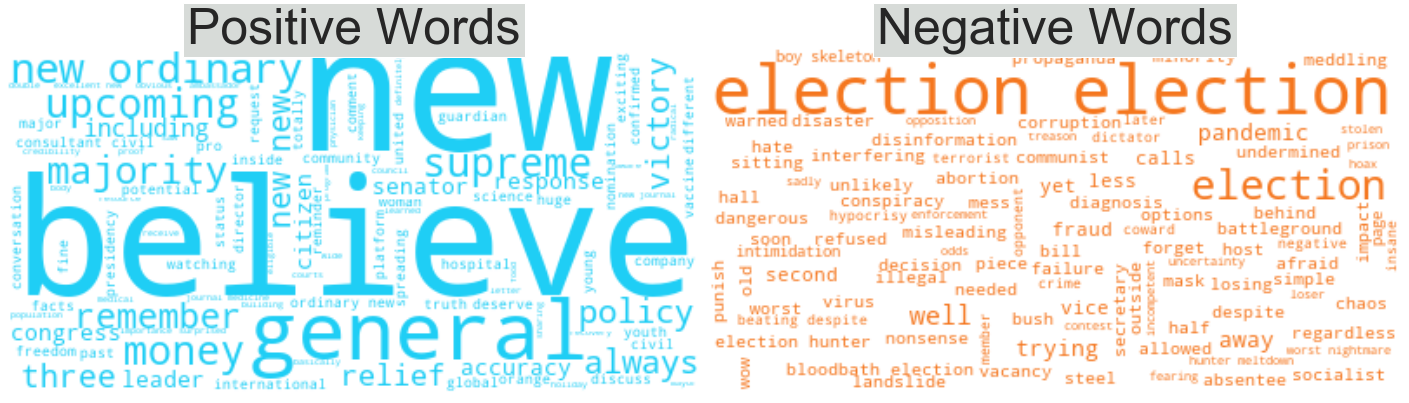

In [28]:
#positive and negative words (x)
pos=[]
neg=[]
for idx, tweet in df.iterrows():
    text_object=NRCLex(tweet.contents)
    for word in text_object.affect_dict.keys():
        if 'positive' in text_object.affect_dict[word] and 'negative' not in text_object.affect_dict[word]:
            pos.append(word)
        elif 'negative' in text_object.affect_dict[word] and 'positive' not in text_object.affect_dict[word]:
            neg.append(word)
def pos_color(word, font_size,font_path, position, orientation, random_state=None):
    return '#1FCEF5'
def neg_color(word,font_size,font_path,position,orientation,random_state=None):
    return '#F5771F'
pos_str=" ".join(word for word in pos)
neg_str=" ".join(word for word in neg)
cloud_pos=WordCloud(max_font_size=100, max_words=100, background_color='white', random_state=42).generate(pos_str)
cloud_pos.recolor(color_func=pos_color)
cloud_neg=WordCloud(max_font_size=100, max_words=100, background_color='white', random_state=42).generate(neg_str)
cloud_neg.recolor(color_func=neg_color)
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(cloud_pos, interpolation='bilinear')
plt.title('Positive Words', fontdict={'fontsize': 50}, bbox={'facecolor':'#d7dbd8','ec':'white'})
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(cloud_neg, interpolation='bilinear')
plt.title('Negative Words', fontdict={'fontsize':50},bbox={'facecolor':'#d7dbd8','ec':'white'})
plt.subplots_adjust(wspace=0.01)

# Frequent Hashtags and Mentions

We look at the most popular hashtags and most frequently mentioned users.

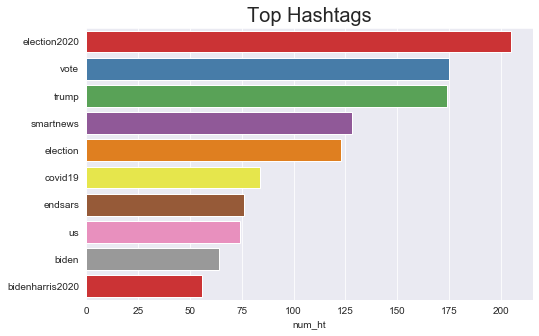

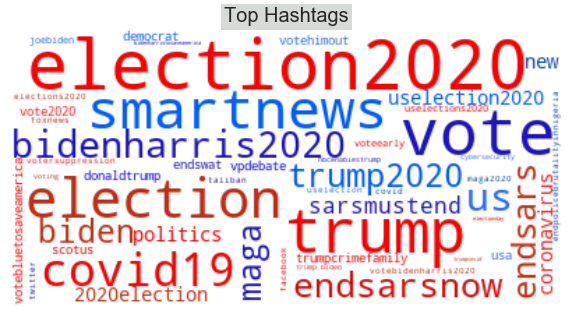

In [30]:
hashtags=[ht for ht_list in df.hashtag.apply(literal_eval).values for ht in ht_list]
d = {ht:hashtags.count(ht) for ht in hashtags}
d=pd.DataFrame.from_dict(d, orient='index',columns=['num_ht'])
d.sort_values(by='num_ht', ascending=False, inplace=True)
plt.figure(figsize=(8,5))
sns.barplot(x=d.iloc[:10].num_ht, y=d.index[:10], palette='Set1');
plt.title('Top Hashtags', fontsize=20)

def rb_color(word,font_size,font_path,position,orientation,random_state=None):
    return random.choice(['#f21f1f','#d90b0b','#fc0000','#c22c15','#c23215','#1e15c2','#0d00ff','#005eff','#0546b5','#2b6bff'])
def r_color(word,font_size,font_path,position,orientation,random_state=None):
    return random.choice(['#f21f1f','#d90b0b','#fc0000','#c22c15','#c23215'])
def b_color(word,font_size,font_path,position,orientation,random_state=None):
    return random.choice(['#1e15c2','#0d00ff','#005eff','#0546b5','#2b6bff'])


ht_str=" ".join(word for word in hashtags)
cloud_ht=WordCloud(max_font_size=50, max_words=50, background_color='white', random_state=42).generate(ht_str)
cloud_ht.recolor(color_func=rb_color)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Top Hashtags', fontdict={'fontsize':20},bbox={'facecolor':'#d7dbd8','ec':'white'})
plt.imshow(cloud_ht, interpolation='bilinear');

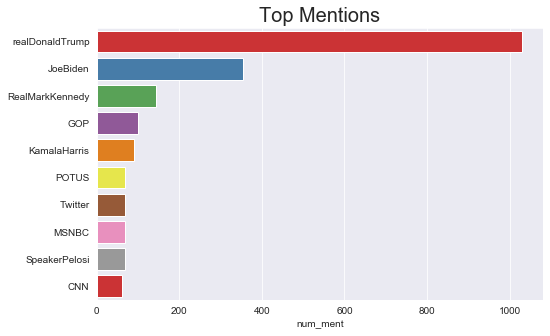

In [31]:
mentions=[ment_dict['screen_name'] for ment_list in df.mentions.apply(literal_eval).values for ment_dict in ment_list]
ment_counts=pd.DataFrame.from_dict({ment:mentions.count(ment) for ment in mentions}, orient='index', columns=['num_ment'])
ment_counts.sort_values(by='num_ment', ascending=False, inplace=True)
plt.figure(figsize=(8,5))
plt.title('Top Mentions', fontsize=20)
sns.barplot(x=ment_counts.iloc[:10].num_ment,y=ment_counts.index[:10], palette='Set1');

# Overall Frequent Words

We use a wordcloud to examine the most frequently occuring words/phrases within all the tweets. The python WordCloud package enables you to mask the wordcloud with an image, which I have attempted here. 

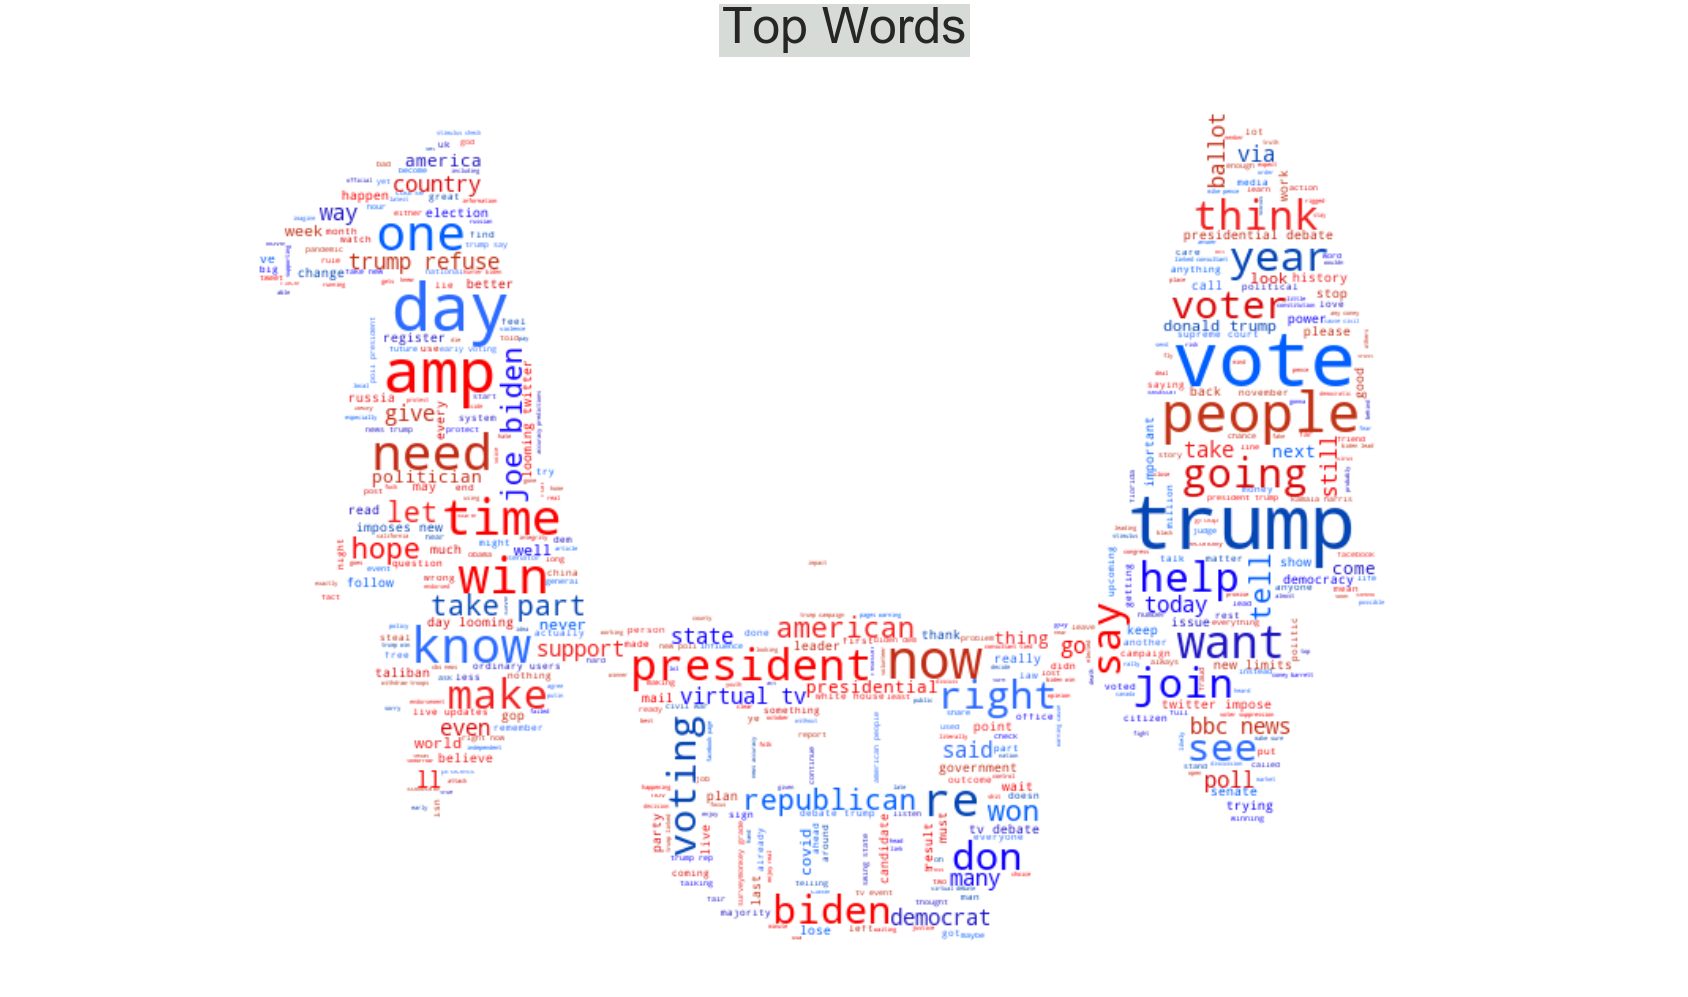

In [32]:
#overall wordcloud
all_str=" ".join(cont for cont in list(df.contents))
all_str=all_str.replace(' election ',' ')
all_str=all_str.replace(' us ',' ')
all_str=all_str.replace(' will ',' ')
img=Image.open('TrumpBidenWhite2.png')
mask=np.array(img)
img_color=ImageColorGenerator(mask)

wc=WordCloud(background_color='white', mask=mask, max_font_size=100, max_words=2000, random_state=42)

wcloud=wc.generate(all_str)
plt.figure(figsize=(30,30))
plt.axis('off')
plt.title('Top Words', fontdict={'fontsize':50},bbox={'facecolor':'#d7dbd8','ec':'white'})
plt.imshow(wc.recolor(color_func=rb_color),interpolation='bilinear')
plt.show()

# Locations 

Due to the general challenge without paying for the Google API, this only focuses on locations where the state is referenced. Others are omitted as it is difficult to infer these.

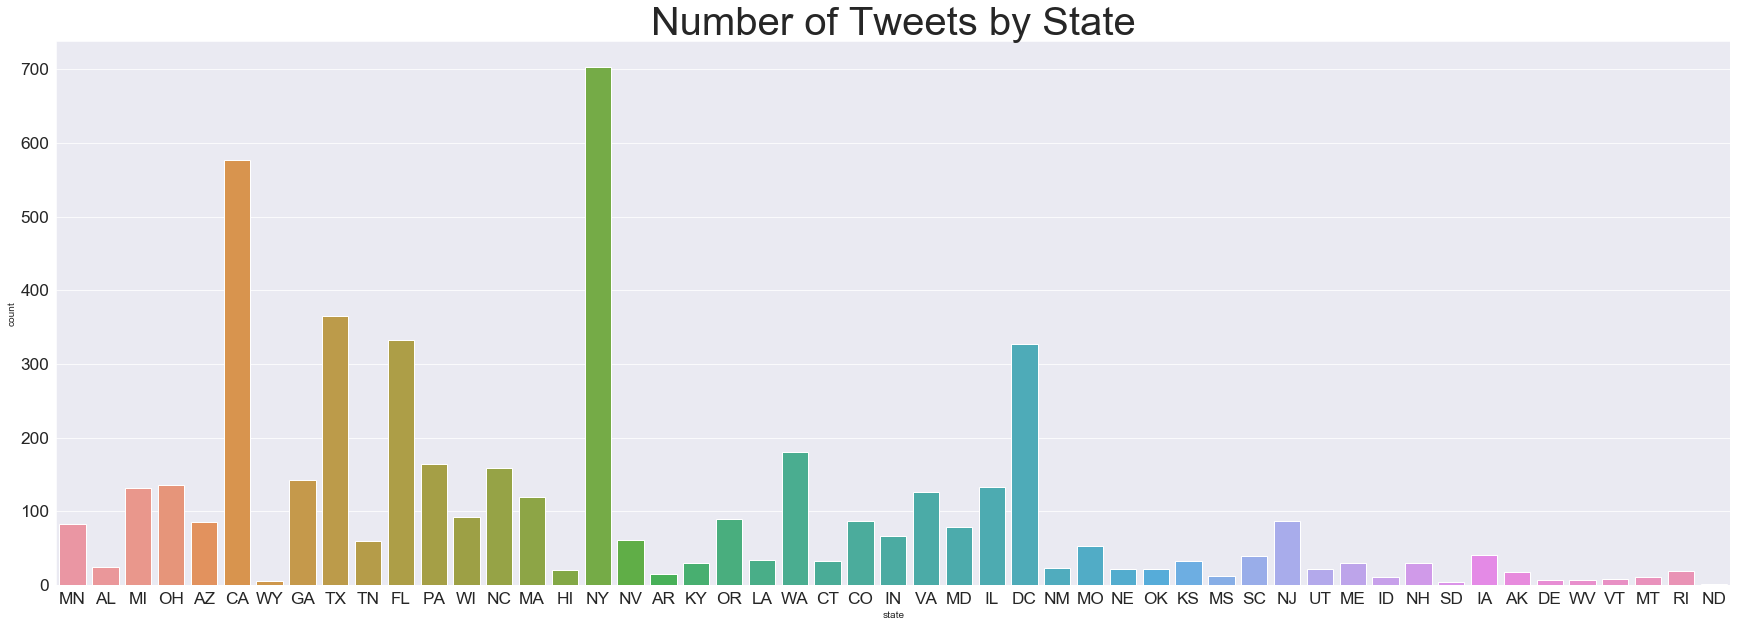

In [33]:
states=['AL','AK','AZ','AR','CA','CO','CT','DE','DC','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME', \
       'MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI',\
       'SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY']
states_full=['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 
             'District of Columbia','Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 
             'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 
             'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
             'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island',
             'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 
             'West Virginia', 'Wisconsin', 'Wyoming']

def get_state(place):
    for state in states:
        try:
            if ' '+state in place:
                return state
        except TypeError:
            continue
    for state in states_full:
        try:
            if state in place:
                return states[states_full.index(state)]
        except TypeError:
            continue
    return None

df['state']=df['location'].apply(get_state)

plt.figure(figsize=(30,10))
plt.xticks(fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.title('Number of Tweets by State', fontsize=40)
sns.countplot(data=df, x='state');

# Biden2020 vs. Trump2020 

We look at how tweets supporting Trump compare to tweets supporting Biden, using a variety of hashtags to identify tweets supporting the candidates (currently just Trump2020 and Biden2020). We use a variety of the above techniques to examine the tweets in each group. 

In [17]:
def get_tweets(hashtags):
    index=[]
    for idx, tweet in df.iterrows():
        for hashtag in hashtags:
            if hashtag in literal_eval(tweet.hashtag):
                index.append(idx)
                break
    return df.iloc[index].copy()

biden_tweets=get_tweets(['biden2020']).reset_index(drop=True)
trump_tweets=get_tweets(['trump2020']).reset_index(drop=True)


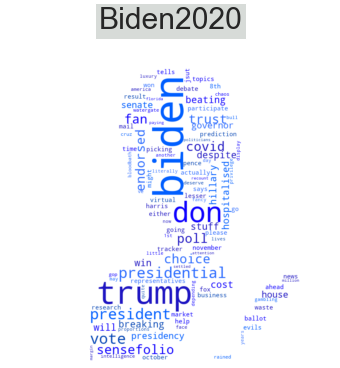

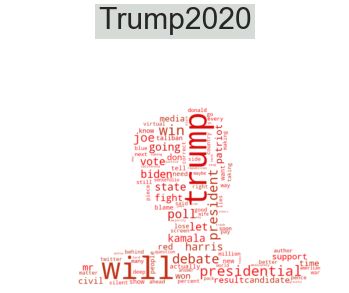

In [35]:
trump2020_words=[]
biden2020_words=[]

for idx, tweet in biden_tweets.iterrows():
    biden2020_words.append(tweet.contents)
for idx, tweet in trump_tweets.iterrows():
    trump2020_words.append(tweet.contents)

trump2020=" ".join(trump2020_words)
biden2020=" ".join(biden2020_words)
trump2020=trump2020.replace(' election ',' ')
trump2020=trump2020.replace(' us ',' ')
biden2020=biden2020.replace(' election ',' ')
biden2020=biden2020.replace(' us ',' ')

img_trump=Image.open('trumpwhite.png')
mask_trump=np.array(img_trump)
                     
img_biden=Image.open('bidenwhite.png')
mask_biden=np.array(img_biden)

wc_trump=WordCloud(background_color='white', mask=mask_trump, max_font_size=100, max_words=100, random_state=42).generate(trump2020)
wc_biden=WordCloud(background_color='white', mask=mask_biden, max_font_size=100, max_words=100, random_state=42).generate(biden2020)

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(wc_biden.recolor(color_func=b_color), interpolation='bilinear')
plt.title('Biden2020', fontdict={'fontsize':30},bbox={'facecolor':'#d7dbd8','ec':'white'})
plt.show()

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(wc_trump.recolor(color_func=r_color),interpolation='bilinear')
plt.title('Trump2020', fontdict={'fontsize':30},bbox={'facecolor':'#d7dbd8','ec':'white'})
plt.show()

#need to crop the Trump photo

# Biden vs. Trump Sentiment

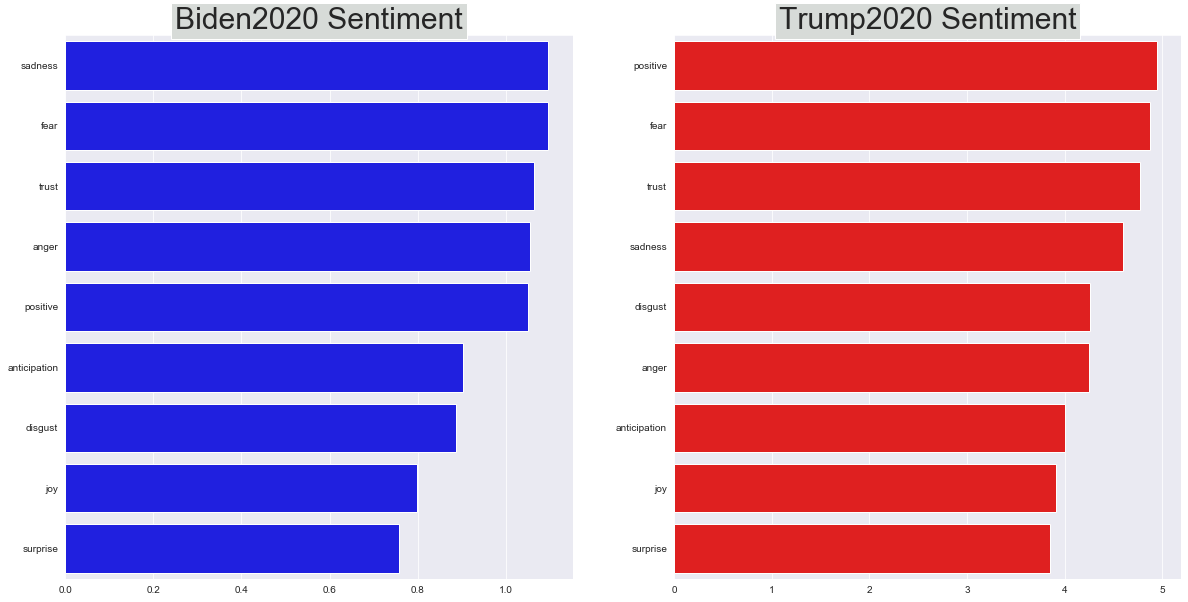

In [36]:
def get_sent(hashtags):
    index=[]
    for idx, tweet in df.iterrows():
        for hashtag in hashtags:
            if hashtag in literal_eval(tweet.hashtag):
                index.append(idx)
                break
    return emot_sent.iloc[index]

biden_sent=get_sent(['biden2020'])
trump_sent=get_sent(['trump2020'])

biden_feelings=biden_sent.sum(axis=0).iloc[1:]
biden_feelings.sort_values(ascending=False, inplace=True)
trump_feelings=trump_sent.sum(axis=0).iloc[1:]
trump_feelings.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.barplot(x=biden_feelings.iloc[1:].values, y=biden_feelings.index[1:], color='blue')
plt.title('Biden2020 Sentiment', fontdict={'fontsize':30},bbox={'facecolor':'#d7dbd8','ec':'white'})
plt.subplot(1,2,2)
sns.barplot(x=trump_feelings.iloc[1:].values, y=trump_feelings.index[1:],color='red')
plt.title('Trump2020 Sentiment', fontdict={'fontsize':30},bbox={'facecolor':'#d7dbd8','ec':'white'})
plt.subplots_adjust(wspace=0.2)



# Biden vs. Trump Location

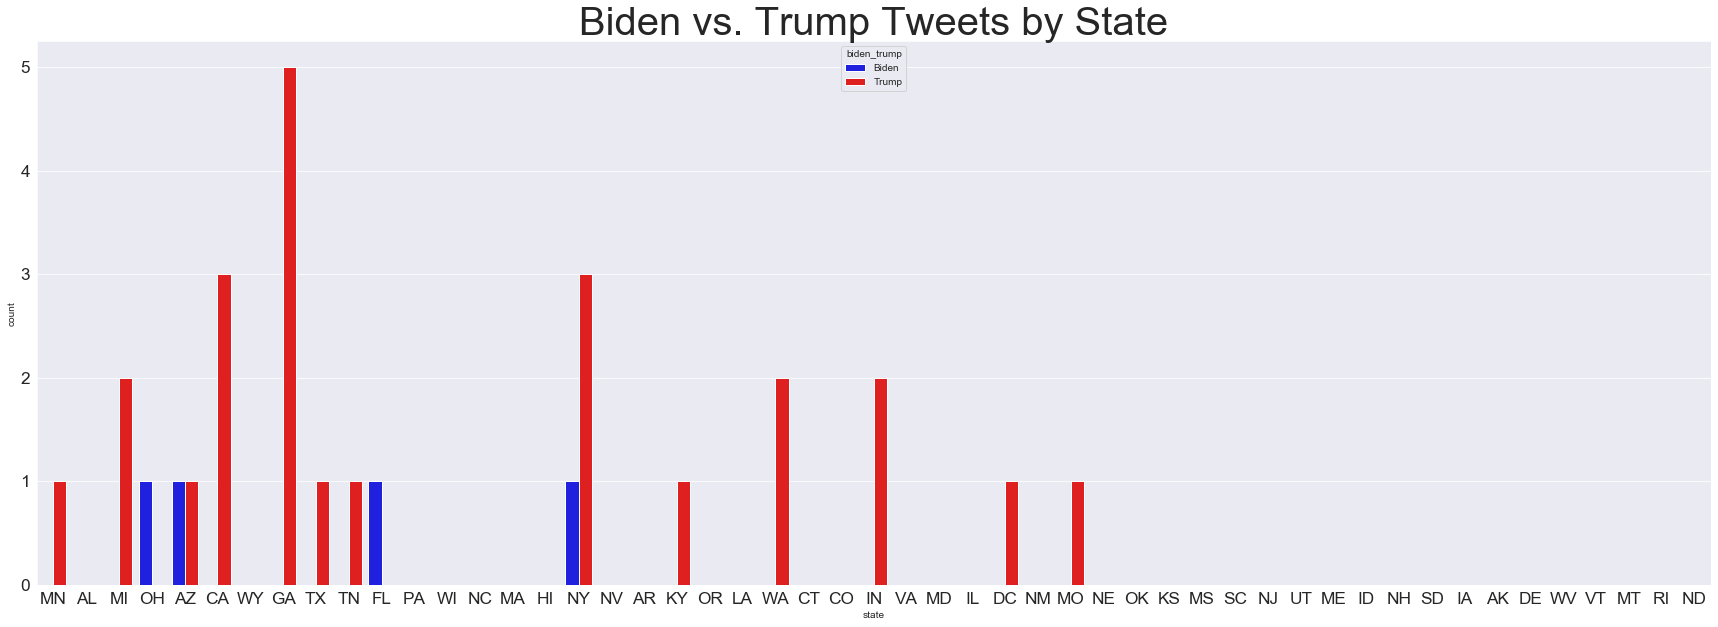

In [37]:
def get_biden_trump(hashtags): #keep this but expand as necessary
    if 'biden2020' in hashtags:
        return 'Biden'
    elif 'trump2020' in hashtags:
        return 'Trump'
df['biden_trump']=df['hashtag'].apply(get_biden_trump)
    
plt.figure(figsize=(30,10))
sns.countplot(data=df, x='state', hue='biden_trump', palette=['blue','red'])
plt.xticks(fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.title('Biden vs. Trump Tweets by State', fontsize=40);


# Biden vs. Trump User Creation Date

This could be useful for detecting bot/troll accounts. 

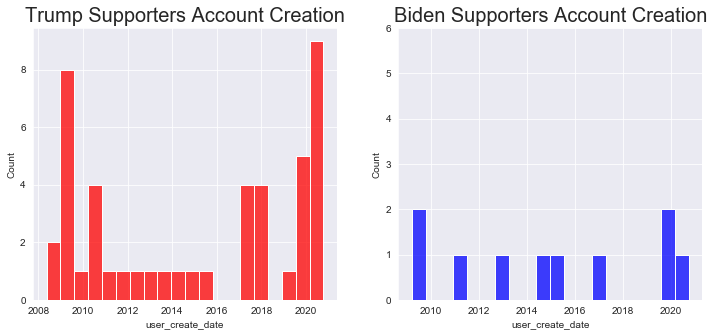

In [38]:
def get_date(dt_str):
    date_time=datetime.datetime.strptime(dt_str, '%Y-%m-%d %H:%M:%S')
    return date_time.date()

df['user_create_date']=df['user_create'].apply(get_date)
df['tweet_create_date']=df['tweet_create'].apply(get_date)

biden_tweets['user_create_date']=biden_tweets['user_create'].apply(get_date)
trump_tweets['user_create_date']=trump_tweets['user_create'].apply(get_date)
biden_tweets['user_create_date']=biden_tweets['user_create_date'].apply(pd.to_datetime)
trump_tweets['user_create_date']=trump_tweets['user_create_date'].apply(pd.to_datetime)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(data=trump_tweets, x='user_create_date',bins=20, stat='count', color='red')
plt.title('Trump Supporters Account Creation', fontsize=20)
plt.subplot(1,2,2)
sns.histplot(data=biden_tweets, x='user_create_date', bins=20, stat='count',color='blue')
plt.title('Biden Supporters Account Creation',fontsize=20)
plt.ylim(top=6);

# Biden vs. Trump Likes and Retweets

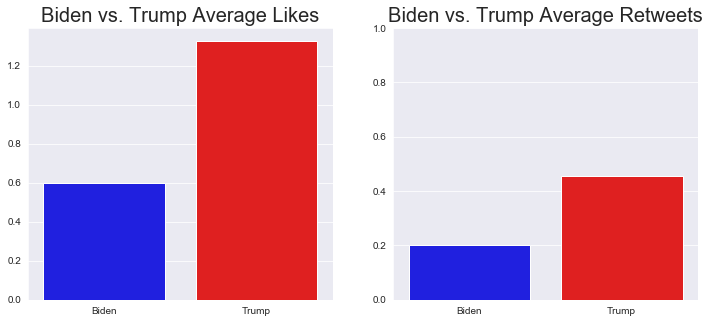

In [39]:
keys=['Biden','Trump']
likes=[biden_tweets['likes'].mean(), trump_tweets['likes'].mean()]
retweets=[biden_tweets['retweets'].mean(), trump_tweets['retweets'].mean()]
colrs=['red' if x=='Trump' else 'blue' for x in keys]
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.barplot(x=keys, y=likes, palette=colrs)
plt.title('Biden vs. Trump Average Likes', fontsize=20)
plt.subplot(1,2,2)
sns.barplot(x=keys, y=retweets, palette=colrs)
plt.title('Biden vs. Trump Average Retweets', fontsize=20)
plt.ylim(top=1);

In [40]:
#jupyter nbconvert --to pdf --TemplateExporter.exclude_input=True Overall\ Analysis.ipynb